<a href="https://colab.research.google.com/github/wannabegeek/CollabNotebooks/blob/main/EURUSD_Prediction_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Stock Price Prediction in Tensorflow

In [89]:
!pip install seaborn

## Setup
Import some things

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

plt.style.use('seaborn-deep')

In [91]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

print(tf.__version__)

2.4.0


## Load the sample data
Import the Sample data as a CSV using pandas

In [92]:
import io
column_names = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

raw_dataset = pd.read_csv('EURUSD.csv', names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

In [93]:
dataset = raw_dataset.copy()
dataset.tail()

,timestamp,open,high,low,close,volume
994,1432860600000,1.095800,1.095955,1.095620,1.095925,0
995,1432860900000,1.095930,1.096145,1.095930,1.096035,0
996,1432861200000,1.096005,1.096430,1.095955,1.096335,0
997,1432861500000,1.096335,1.096465,1.095945,1.095955,0
998,1432861800000,1.095980,1.096340,1.095845,1.096335,0


Check the data is all valid (i.e. do we have data in all columns)

In [94]:
dataset.isna().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

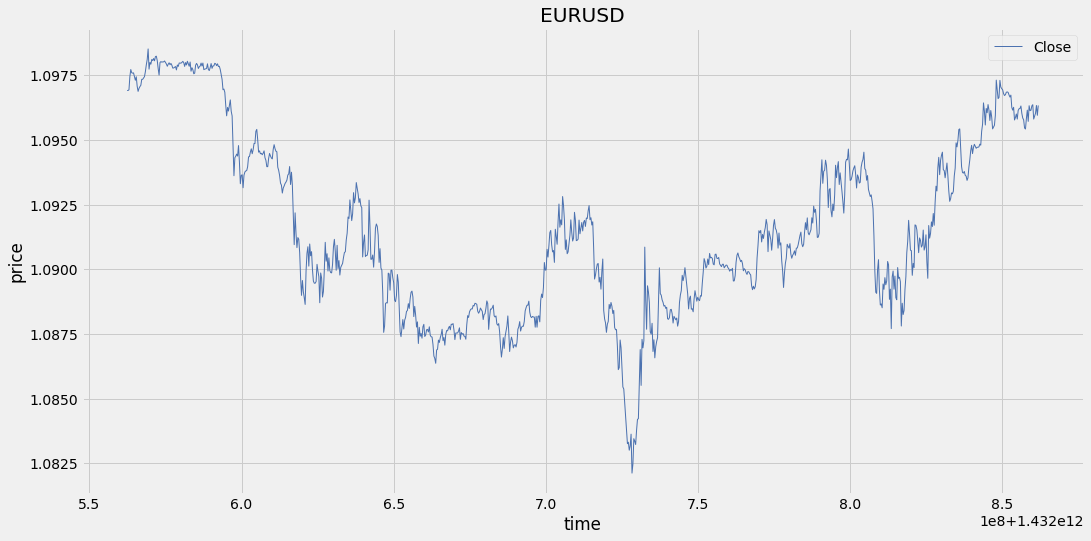

In [95]:
plt.figure(figsize=(16,8))
# plt.plot(dataset['timestamp'], dataset['open'], label="Open", linewidth=1)
plt.plot(dataset['timestamp'], dataset['close'], label="Close", linewidth=1)
plt.plot()

plt.xlabel("time")
plt.ylabel("price")
plt.title("EURUSD")
plt.legend()
plt.show()

## Prepare the data ready for training

In [98]:
closing_prices = raw_dataset.filter(['close'])

In [99]:
import math

training_data_len = math.ceil(len(closing_prices) * 0.8)

I is a good idea to normalise the data before supplying it to Tensorflow (or any deep learning algorithm)


In [116]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices)

Create the training data.
This is where we may want to add differnt dimentions etc. to aid the learning.

In [103]:
training_data = scaled_data[0:training_data_len, :]

historical_data = []
target_data = []

history_len = 50

for i in range(history_len, len(training_data)):
  historical_data.append(training_data[i - history_len:i, 0])
  target_data.append(training_data[i, 0])

historical_data, target_data = np.array(historical_data), np.array(target_data)


Reshape the data

LSTM networks expect the data to be 3-dimentional
In our case
- Number of data-point for training
- The data at the various timestamps (this is the len of the historical data we are giving each data-point)
- Number of features (in this case, we are only using closing price, so it is 1)

In [104]:
historical_data = np.reshape(historical_data, (historical_data.shape[0], historical_data.shape[1], 1))

# Check the shape is correct
historical_data.shape

(750, 50, 1)

## Build LSTM and Train

In [105]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(historical_data.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

Compile the Model


In [106]:
model.compile(optimizer='adam', loss='mean_squared_error')

Train the model with the data

In [107]:
model.fit(historical_data, target_data, batch_size=1, epochs=1)

750/750 [==============================] - 19s 21ms/step - loss: 0.0142


In [122]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


## Testing the model
...and figure out how accurate it is

In [108]:
test_data = scaled_data[training_data_len - history_len: , :]

historical_test_data = []
target_test_data = scaled_data[training_data_len:, :]

for i in range(history_len, len(test_data)):
  historical_test_data.append(test_data[i-history_len:i, 0])


Convert to numpy array & reshape


In [109]:
historical_test_data = np.array(historical_test_data)

historical_test_data = np.reshape(historical_test_data, (historical_test_data.shape[0], historical_test_data.shape[1], 1))

Get the model predicted values

In [110]:
predictions = model.predict(historical_test_data)
predictions = scaler.inverse_transform(predictions)

Get the Root Mean Squared Error (RMSE)

The closer to zero the better

In [113]:
rmse = np.sqrt(np.mean(predictions - target_test_data) ** 2)
rmse

0.40750149448233836

Plot thre results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


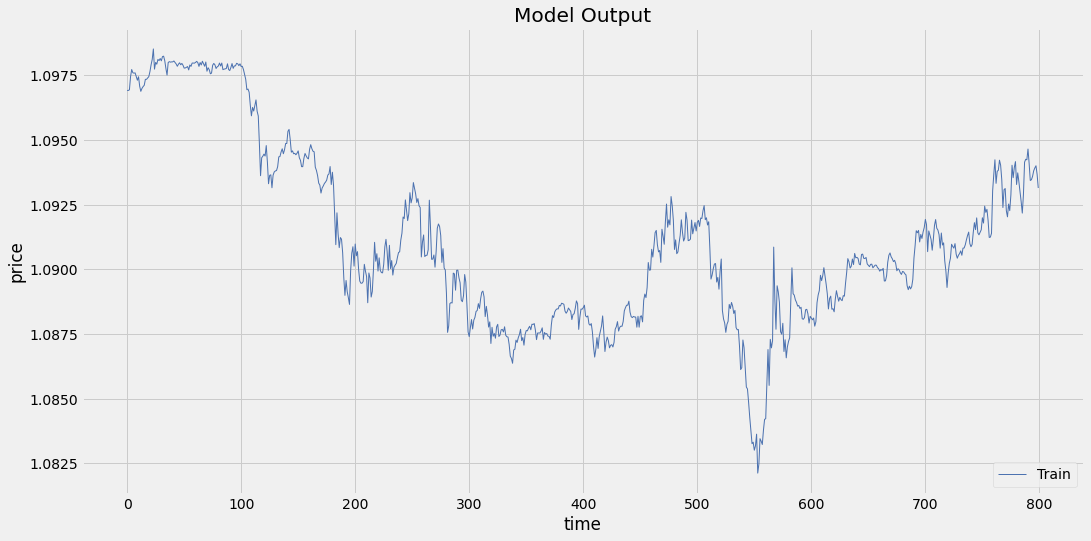

In [121]:
train = dataset[:training_data_len]
valid = dataset[training_data_len:]
valid['predictions'] = predictions

plt.figure(figsize=(16,8))

plt.plot(train['close'], linewidth=1)
plt.plot(valid[['close', 'predictions']], linewidth=1)
plt.plot()

plt.xlabel("time")
plt.ylabel("price")
plt.title("Model Output")
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()